# Imports

In [1]:
import os

In [2]:
import numpy as np
import pandas as pd

In [3]:
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
MAPBOX_STYLE = "dark"
MAPBOX_HEIGHT = 800
%matplotlib inline
import matplotlib.font_manager
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

px.set_mapbox_access_token(os.getenv("MAPBOX_TOKEN"))
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext="ttf")
plt.style.use("seaborn-colorblind")
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Open Sans"
plt.rcParams["figure.figsize"] = 15, 6
plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
from mlxtend.plotting import plot_decision_regions
from sklearn.ensemble import (
    AdaBoostClassifier,
    BaggingClassifier,
    GradientBoostingRegressor,
    RandomForestRegressor,
    VotingClassifier,
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    mean_squared_error,
    plot_precision_recall_curve,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

# Functions

In [5]:
def plot_labeled_decision_regions(X, y, models):
    """
    Function producing a scatter plot of the instances contained
    in the 2D dataset (X,y) along with the decision
    regions of two trained classification models contained in the
    list 'models'.

    Parameters
    ----------
    X: pandas DataFrame corresponding to two numerical features
    y: pandas Series corresponding the class labels
    models: list containing two trained classifiers

    """
    if len(models) != 2:
        raise Exception(
            """
        Models should be a list containing only two trained classifiers.
        """
        )
    if not isinstance(X, pd.DataFrame):
        raise Exception(
            """
        X has to be a pandas DataFrame with two numerical features.
        """
        )
    if not isinstance(y, pd.Series):
        raise Exception(
            """
        y has to be a pandas Series corresponding to the labels.
        """
        )
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True)
    for i, model in enumerate(models):
        plot_decision_regions(X.values, y.values, model, legend=2, ax=ax[i])
        ax[i].set_title(model.__class__.__name__)
        ax[i].set_xlabel(X.columns[0])
        if i == 0:
            ax[i].set_ylabel(X.columns[1])
        ax[i].set_ylim(X.values[:, 1].min(), X.values[:, 1].max())
        ax[i].set_xlim(X.values[:, 0].min(), X.values[:, 0].max())
    plt.tight_layout()
    plt.show()

In [6]:
def plot_feature_importances(X, model):
    rf_std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
    rf_importances = pd.DataFrame(
        dict(feature=X.columns, importance=rf.feature_importances_, errs=rf_std)
    )
    rf_importances.sort_values(by=["importance"], ascending=False, inplace=True)
    sns.barplot(x="importance", y="feature", data=rf_importances)
    plt.errorbar(
        y=range(len(rf_importances.feature)),
        x=rf_importances.importance,
        xerr=rf_importances.errs,
        fmt="none",
        c="black",
    )

# Classification and Regression Trees (CARTs)

## Cancer (Classification)

### Data

In [7]:
df = pd.read_csv("datasets/wbc.csv")
df.sample(10)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
273,8910996,B,9.742,15.67,61.50,289.9,0.09037,0.04689,0.011030,0.014070,...,20.88,68.09,355.2,0.14670,0.09370,0.040430,0.05159,0.2841,0.08175,NaN
546,922577,B,10.320,16.35,65.31,324.9,0.09434,0.04994,0.010120,0.005495,...,21.77,71.12,384.9,0.12850,0.08842,0.043840,0.02381,0.2681,0.07399,NaN
534,919537,B,10.960,17.62,70.79,365.6,0.09687,0.09752,0.052630,0.027880,...,26.51,76.43,407.5,0.14280,0.25100,0.212300,0.09861,0.2289,0.08278,NaN
275,8911164,B,11.890,17.36,76.20,435.6,0.12250,0.07210,0.059290,0.074040,...,18.99,79.46,472.4,0.13590,0.08368,0.071530,0.08946,0.2220,0.06033,NaN
290,89143602,B,14.410,19.73,96.03,651.0,0.08757,0.16760,0.136200,0.066020,...,22.13,101.70,767.3,0.09983,0.24720,0.222000,0.10210,0.2272,0.08799,NaN
245,884437,B,10.480,19.86,66.72,337.7,0.10700,0.05971,0.048310,0.030700,...,29.46,73.68,402.8,0.15150,0.10260,0.118100,0.06736,0.2883,0.07748,NaN
360,901034302,B,12.540,18.07,79.42,491.9,0.07436,0.02650,0.001194,0.005449,...,20.98,86.82,585.7,0.09293,0.04327,0.003581,0.01635,0.2233,0.05521,NaN
84,8612080,B,12.000,15.65,76.95,443.3,0.09723,0.07165,0.041510,0.018630,...,24.90,87.78,567.9,0.13770,0.20030,0.226700,0.07632,0.3379,0.07924,NaN
239,88330202,M,17.460,39.28,113.40,920.6,0.09812,0.12980,0.141700,0.088110,...,44.87,141.20,1408.0,0.13650,0.37350,0.324100,0.20660,0.2853,0.08496,NaN
40,855167,M,13.440,21.58,86.18,563.0,0.08162,0.06031,0.031100,0.020310,...,30.25,102.50,787.9,0.10940,0.20430,0.208500,0.11120,0.2994,0.07146,NaN


In [8]:
target = "diagnosis"
df[target] = df[target].astype("category").cat.codes
y = df[target]
X = df.drop(target, axis=1)[["radius_mean", "concave points_mean"]]  # .to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1
)

### Decision Tree

In [9]:
# Instantiate dt_entropy, set 'entropy' as the information criterion
dt_gini = DecisionTreeClassifier(max_depth=8, criterion="gini", random_state=1)
dt_entropy = DecisionTreeClassifier(max_depth=8, criterion="entropy", random_state=1)

# Fit dt_entropy to the training set
dt_gini.fit(X_train, y_train)
dt_entropy.fit(X_train, y_train)

# Use dt_entropy to predict test set labels
y_pred = dt_gini.predict(X_test)
accuracy_gini = accuracy_score(y_test, y_pred)
y_pred = dt_entropy.predict(X_test)
accuracy_entropy = accuracy_score(y_test, y_pred)

# Print accuracy
print("Accuracy achieved by using entropy: ", accuracy_entropy)
print("Accuracy achieved by using the gini index: ", accuracy_gini)

Accuracy achieved by using entropy:  0.8859649122807017
Accuracy achieved by using the gini index:  0.9210526315789473


In [10]:
# Instantiate a DecisionTreeClassifier 'dt' with a maximum depth of 6
dt = DecisionTreeClassifier(max_depth=6, random_state=1)

# Setup the hyperparameter grid
param_grid = {"criterion": ["gini", "entropy"]}

# Instantiate the GridSearchCV object: logreg_cv
dt_cv = GridSearchCV(dt, param_grid, n_jobs=-1)

# Fit it to the data
dt_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print(f"CV tuned params: {dt_cv.best_params_}")
print(f"CV best accuracy: {dt_cv.best_score_}")

# Predict test set labels
y_pred = dt_cv.predict(X_test)
print(f"Sample predictions: {y_pred[0:5]}")

# Compute test set accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {acc}")

CV tuned params: {'criterion': 'entropy'}
CV best accuracy: 0.8967032967032967
Sample predictions: [1 0 0 1 0]
Test set accuracy: 0.8947368421052632


### Logistic Regression

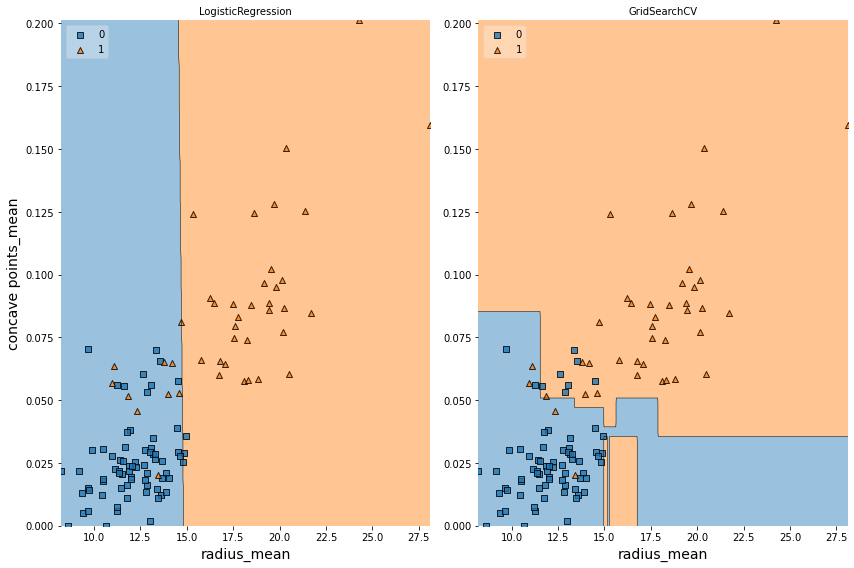

In [11]:
# Instatiate logreg
logreg = LogisticRegression(random_state=1)

# Fit logreg to the training set
logreg.fit(X_train, y_train)

# Define a list called clfs containing the two classifiers logreg and dt
clfs = [logreg, dt_cv]

# Review the decision regions of the two classifiers
plot_labeled_decision_regions(X_test, y_test, clfs)

## Auto MPG (Regression)

### Data

In [12]:
df = pd.read_csv("datasets/auto.csv")
df.sample(10)

,mpg,displ,hp,weight,accel,origin,size
327,32.4,107.0,72,2290,17.0,Asia,10.0
343,24.0,140.0,92,2865,16.4,US,10.0
374,26.0,156.0,92,2585,14.5,US,10.0
131,25.0,97.5,80,2126,17.0,US,10.0
267,11.0,350.0,180,3664,11.0,US,20.0
113,13.0,400.0,170,4746,12.0,US,20.0
362,26.0,97.0,46,1950,21.0,Europe,10.0
115,17.0,260.0,110,4060,19.0,US,20.0
340,14.0,350.0,165,4209,12.0,US,20.0
251,32.0,83.0,61,2003,19.0,Asia,10.0


In [13]:
df = pd.get_dummies(df)
df.sample(10)

,mpg,displ,hp,weight,accel,size,origin_Asia,origin_Europe,origin_US
383,37.7,89.0,62,2050,17.3,10.0,1,0,0
132,33.0,105.0,74,2190,14.2,10.0,0,1,0
329,27.5,134.0,95,2560,14.2,10.0,1,0,0
100,20.0,130.0,102,3150,15.7,10.0,0,1,0
228,19.1,225.0,90,3381,18.7,15.0,0,0,1
240,25.4,183.0,77,3530,20.1,12.5,0,1,0
277,28.0,97.0,92,2288,17.0,10.0,1,0,0
221,28.0,112.0,88,2605,19.6,10.0,0,0,1
88,38.0,91.0,67,1995,16.2,10.0,1,0,0
367,19.0,232.0,100,2901,16.0,15.0,0,0,1


In [14]:
target = "mpg"
y = df[target]
X = df.drop(target, axis=1)

### Baseline Model

The baseline RMSE above which a model is considered to be underfitting and below which the model is considered good enough.

In [15]:
# keep a single feature
X_naive = X["displ"].to_numpy().reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(
    X_naive, y, test_size=0.2, random_state=3
)
dt = DecisionTreeRegressor(max_depth=8, min_samples_leaf=0.13, random_state=3)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
mse_baseline = mean_squared_error(y_test, y_pred)
rmse_baseline = np.sqrt(mse_baseline)

### Decision Tree

In [16]:
# Set SEED for reproducibility
SEED = 1

# Split the data into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED
)

# Instantiate a DecisionTreeRegressor dt
dt_cv = DecisionTreeRegressor(max_depth=4, min_samples_leaf=0.26, random_state=SEED)

# Compute the array containing the 10-folds CV MSEs
mse_cv_scores = -cross_val_score(
    dt_cv, X_train, y_train, cv=10, scoring="neg_mean_squared_error", n_jobs=-1
)

# Compute the 10-folds CV RMSE
rmse_dt_cv = (mse_cv_scores.mean()) ** (1.0 / 2.0)

In [17]:
# Fit dt to the training set
dt_cv.fit(X_train, y_train)

# Predict the labels of the training set
y_pred = dt_cv.predict(X_train)

# Evaluate the training set RMSE of dt
rmse_dt_train = (mean_squared_error(y_train, y_pred)) ** (1.0 / 2.0)

In [18]:
# run on test set
y_pred = dt_cv.predict(X_test)
rmse_dt_test = np.sqrt(mean_squared_error(y_test, y_pred))

### Random Forest

In [19]:
rf = RandomForestRegressor(n_estimators=400, min_samples_leaf=0.12, random_state=SEED)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rmse_rf_test = np.sqrt(mean_squared_error(y_test, y_pred))

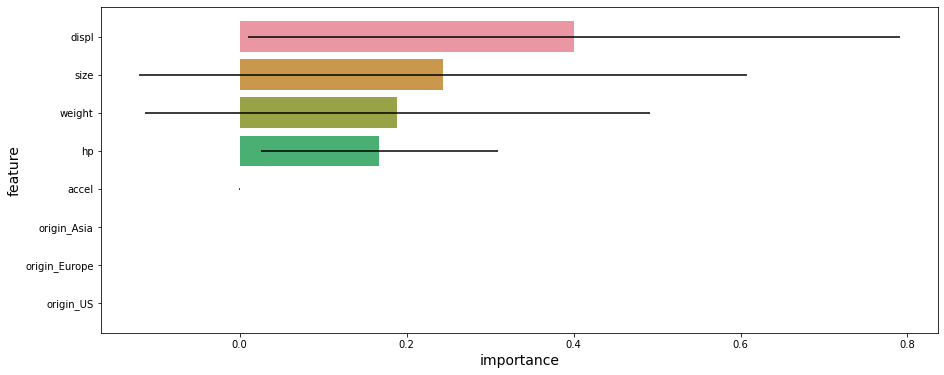

In [20]:
plot_feature_importances(X, rf)

### Gradient Boosting

In [21]:
gbt = GradientBoostingRegressor(n_estimators=300, max_depth=1, random_state=SEED)
gbt.fit(X_train, y_train)
y_pred = gbt.predict(X_test)
rmse_gbt_test = np.sqrt(mean_squared_error(y_test, y_pred))

### Stochastic Gradient Boosting

In [22]:
sgbt = GradientBoostingRegressor(
    max_depth=1, subsample=0.8, max_features=0.2, n_estimators=300, random_state=1
)
sgbt.fit(X_train, y_train)
y_pred = sgbt.predict(X_test)
rmse_sgbt_test = np.sqrt(mean_squared_error(y_test, y_pred))

### Linear Regression

In [23]:
# linear regression for comparison
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
rmse_lr_test = np.sqrt(mean_squared_error(y_test, y_pred))

### Bias Variance Evaluation

In [24]:
print(f"Baseline: {rmse_baseline}")
print()
print(f"DT CV: {rmse_dt_cv}")
print(f"DT Train: {rmse_dt_train}")
print(f"DT Test: {rmse_dt_test}")
print()
print(f"LR Test: {rmse_lr_test}")
print(f"RF Test: {rmse_rf_test}")
print(f"GB Test: {rmse_gbt_test}")
print(f"SGB Test: {rmse_sgbt_test}")

Baseline: 5.040821910883998

DT CV: 5.143255076652255
DT Train: 5.151299302408305
DT Test: 4.859775831709125

LR Test: 3.820965511082005
RF Test: 3.9783131439894097
GB Test: 4.0142669605222805
SGB Test: 3.9542590299829556


It appears the `dt_cv` model suffers from high bias because `rmse_dt_cv` $\approx$ `rmse_dt_train` and both scores are greater than `rmse_baseline`. Thus, the `dt_cv` model appears to be underfitting the training set since the model is too constrained to capture the nonlinear dependencies between features and labels.

# Ensembles

## Cancer

### Data

In [25]:
df = pd.read_csv("datasets/wbc.csv")
df.sample(10)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
502,91505,B,12.54,16.32,81.25,476.3,0.11580,0.10850,0.059280,0.032790,...,21.40,86.67,552.0,0.15800,0.17510,0.18890,0.08411,0.3155,0.07538,NaN
64,85922302,M,12.68,23.84,82.69,499.0,0.11220,0.12620,0.112800,0.068730,...,33.47,111.80,888.3,0.18510,0.40610,0.40240,0.17160,0.3383,0.10310,NaN
387,902976,B,13.88,16.16,88.37,596.6,0.07026,0.04831,0.020450,0.008507,...,19.97,99.66,745.3,0.08484,0.12330,0.10910,0.04537,0.2542,0.06623,NaN
315,894089,B,12.49,16.85,79.19,481.6,0.08511,0.03834,0.004473,0.006423,...,19.71,84.48,544.2,0.11040,0.04953,0.01938,0.02784,0.1917,0.06174,NaN
303,892657,B,10.49,18.61,66.86,334.3,0.10680,0.06678,0.022970,0.017800,...,24.54,70.76,375.4,0.14130,0.10440,0.08423,0.06528,0.2213,0.07842,NaN
236,88299702,M,23.21,26.97,153.50,1670.0,0.09509,0.16820,0.195000,0.123700,...,34.51,206.00,2944.0,0.14810,0.41260,0.58200,0.25930,0.3103,0.08677,NaN
241,883539,B,12.42,15.04,78.61,476.5,0.07926,0.03393,0.010530,0.011080,...,20.37,83.85,543.4,0.10370,0.07776,0.06243,0.04052,0.2901,0.06783,NaN
347,89869,B,14.76,14.74,94.87,668.7,0.08875,0.07780,0.046080,0.035280,...,17.93,114.20,880.8,0.12200,0.20090,0.21510,0.12510,0.3109,0.08187,NaN
225,88143502,B,14.34,13.47,92.51,641.2,0.09906,0.07624,0.057240,0.046030,...,16.90,110.40,873.2,0.12970,0.15250,0.16320,0.10870,0.3062,0.06072,NaN
428,90769601,B,11.13,16.62,70.47,381.1,0.08151,0.03834,0.013690,0.013700,...,20.29,74.35,421.1,0.10300,0.06219,0.04580,0.04044,0.2383,0.07083,NaN


In [26]:
target = "diagnosis"
df[target] = df[target].astype("category").cat.codes
y = df[target]
X = df.drop(target, axis=1)[["radius_mean", "concave points_mean"]]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=1
)

### Voting

In [27]:
lr = LogisticRegression(random_state=42)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=42)
classifiers = [("LogisticRegression", lr), ("KNN", knn), ("DecisionTree", dt)]

for clf_name, clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{clf_name:20s} :: {accuracy:0.3f}")

vc = VotingClassifier(estimators=classifiers)
vc.fit(X_train, y_train)
y_pred = vc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Voting :: {accuracy:0.3f}")

LogisticRegression   :: 0.877
KNN                  :: 0.865
DecisionTree         :: 0.912
Voting :: 0.877


### Bagging w/ OOB

In [28]:
dt = DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.16, random_state=1)
bc = BaggingClassifier(base_estimator=dt, oob_score=True, n_estimators=300, n_jobs=-1)
bc.fit(X_train, y_train)
y_pred = bc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy_oob = bc.oob_score_
print(f"Bagging Classifier Test :: {accuracy:0.3f}")
print(f"Bagging Classifier OOB :: {accuracy_oob:0.3f}")

Bagging Classifier Test :: 0.877
Bagging Classifier OOB :: 0.915


### Boosting

In [29]:
# decision stump
dt = DecisionTreeClassifier(max_depth=1, random_state=1)

# adaboost the stumps
adb_clf = AdaBoostClassifier(base_estimator=dt, n_estimators=100)

# fit
adb_clf.fit(X_train, y_train)
y_pred_proba = adb_clf.predict_proba(X_test)[:, 1]
score = roc_auc_score(y_test, y_pred_proba)
print(f"ROC score: {score}")

ROC score: 0.9575788551401869


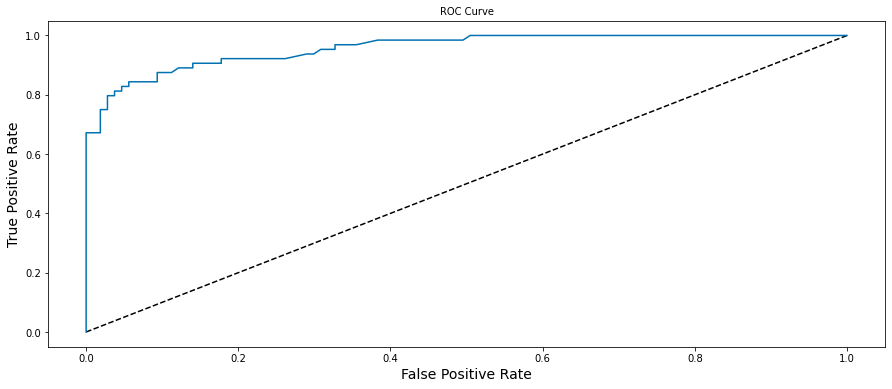

In [30]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

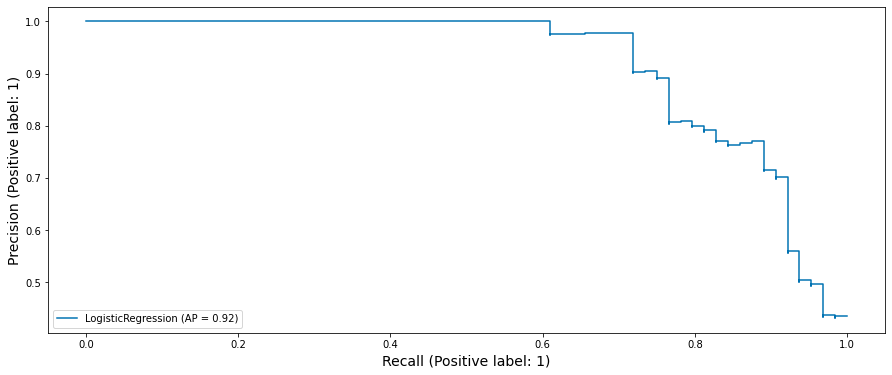

In [31]:
disp = plot_precision_recall_curve(logreg, X_test, y_test)

## Liver Disease

### Data

In [32]:
df = pd.read_csv("datasets/indian_liver_patient_preprocessed.csv")
df.sample(10)

,Unnamed: 0,Age_std,Total_Bilirubin_std,Direct_Bilirubin_std,Alkaline_Phosphotase_std,Alamine_Aminotransferase_std,Aspartate_Aminotransferase_std,Total_Protiens_std,Albumin_std,Albumin_and_Globulin_Ratio_std,Is_male_std,Liver_disease
267,270,-0.480164,-0.420320,-0.459878,-0.231624,0.081267,-0.194802,2.785177,2.219199,0.165780,1,1
16,16,-0.418465,-0.243537,-0.246664,0.208069,0.474657,1.141526,1.031931,1.589276,1.105288,1,1
131,131,1.555897,-0.420320,-0.459878,-0.223406,-0.344905,-0.284581,-0.629039,-0.804430,-0.617144,0,0
271,274,-0.726959,-0.243537,-0.246664,-0.391887,-0.306659,-0.305299,1.401035,1.085338,0.165780,1,1
425,429,1.740993,-0.227466,-0.282199,5.993940,0.114050,0.105613,-0.905868,-1.434352,-1.400067,1,1
506,510,-0.480164,-0.404249,-0.459878,-0.354903,-0.273876,-0.256957,2.508349,1.841245,0.165780,0,0
243,245,0.568716,-0.388178,-0.459878,-0.005614,-0.361296,-0.319111,-0.352211,-0.426476,-0.460559,1,1
455,459,1.247403,-0.356035,-0.353271,1.621662,-0.355832,-0.222426,-0.721316,-2.064275,-1.869821,1,1
54,54,-0.171670,0.897513,1.068160,-0.079581,-0.273876,-0.170630,-0.629039,-1.434352,-1.400067,1,1
246,248,-0.295067,-0.420320,-0.495414,-0.367231,-0.241094,-0.281128,-1.367248,-0.678445,0.165780,1,1


In [33]:
target = "Liver_disease"
y = df[target]
X = df.drop(target, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

### Voting

In [34]:
# Instantiate lr
lr = LogisticRegression(random_state=1)

# Instantiate knn
knn = KNeighborsClassifier(n_neighbors=27)

# Instantiate dt
dt = DecisionTreeClassifier(min_samples_leaf=0.13, random_state=1)

# Define the list classifiers
classifiers = [
    ("Logistic Regression", lr),
    ("K Nearest Neighbours", knn),
    ("Classification Tree", dt),
]

# Iterate over the pre-defined list of classifiers
for clf_name, clf in classifiers:
    # Fit clf to the training set
    clf.fit(X_train, y_train)

    # Predict y_pred
    y_pred = clf.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Evaluate clf's accuracy on the test set
    print(f"{clf_name:s} : {accuracy:.3f}")

# Instantiate a VotingClassifier vc
vc = VotingClassifier(estimators=classifiers)

# Fit vc to the training set
vc.fit(X_train, y_train)

# Evaluate the test set predictions
y_pred = vc.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_pred, y_test)
print(f"Voting Classifier: {accuracy:.3f}")

Logistic Regression : 0.764
K Nearest Neighbours : 0.724
Classification Tree : 0.730
Voting Classifier: 0.764


/home/kcavagnolo/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/kcavagnolo/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

### Bagging w/ OOB

In [35]:
# Instantiate dt
dt = DecisionTreeClassifier(min_samples_leaf=8, random_state=1)

# Instantiate bc
bc = BaggingClassifier(
    base_estimator=dt, oob_score=True, n_estimators=50, random_state=1
)

In [36]:
# Fit bc to the training set
bc.fit(X_train, y_train)

# Predict test set labels
y_pred = bc.predict(X_test)

# Evaluate acc_test
accuracy = accuracy_score(y_test, y_pred)
accuracy_oob = bc.oob_score_
print(f"Bagging Classifier Test :: {accuracy:0.3f}")
print(f"Bagging Classifier OOB :: {accuracy_oob:0.3f}")

Bagging Classifier Test :: 0.695
Bagging Classifier OOB :: 0.677


### Adaboost w/ DT

In [37]:
# Instantiate dt
dt = DecisionTreeClassifier(max_depth=2, random_state=1)

# Instantiate ada
ada = AdaBoostClassifier(base_estimator=dt, n_estimators=180, random_state=1)

# Fit ada to the training set
ada.fit(X_train, y_train)

# Compute the probabilities of obtaining the positive class
y_pred_proba = ada.predict_proba(X_test)[:, 1]

In [38]:
# Evaluate test-set roc_auc_score
ada_roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print roc_auc_score
print(f"ROC AUC score: {ada_roc_auc:.2f}")

ROC AUC score: 0.72


### Grid Search w/ DT

In [39]:
# Define params_dt
params_dt = dict(
    max_depth=np.arange(2, 5, 1), min_samples_leaf=np.arange(0.12, 0.19, 0.02)
)

# Instantiate grid_dt
dt = DecisionTreeClassifier()
grid_dt = GridSearchCV(
    estimator=dt, param_grid=params_dt, scoring="roc_auc", cv=5, n_jobs=-1
)

# fit
grid_dt.fit(X_train, y_train)

# Extract the best estimator
best_model = grid_dt.best_estimator_

# Predict the test set probabilities of the positive class
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Compute test_roc_auc
test_roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print test_roc_auc
print(f"Test set ROC AUC score: {test_roc_auc:.3f}")

Test set ROC AUC score: 0.707


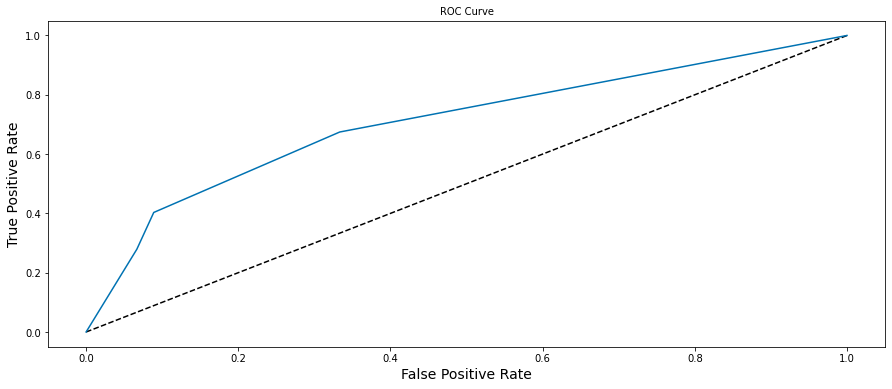

In [40]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

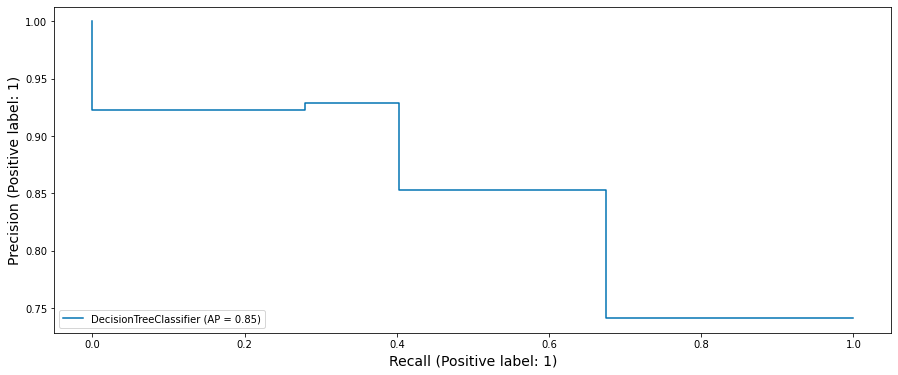

In [41]:
disp = plot_precision_recall_curve(best_model, X_test, y_test)

## Bike Sharing

### Data

In [42]:
df = pd.read_csv("datasets/bikes.csv")
df.columns = [c.lower().replace(" ", "_") for c in df.columns]
df.sample(10)

,hr,holiday,workingday,temp,hum,windspeed,cnt,instant,mnth,yr,clear_to_partly_cloudy,light_precipitation,misty
733,13,0,1,0.80,0.55,0.2836,288,13737,7,1,1,0,0
432,0,0,1,0.74,0.66,0.0896,66,13436,7,1,1,0,0
58,10,0,1,0.82,0.43,0.2239,209,13062,7,1,1,0,0
1061,5,0,1,0.68,0.89,0.1940,36,14065,8,1,0,0,1
89,17,1,0,0.92,0.35,0.2985,414,13093,7,1,1,0,0
1066,10,0,1,0.70,0.79,0.1045,208,14070,8,1,1,0,0
90,18,1,0,0.90,0.42,0.1940,430,13094,7,1,1,0,0
240,0,0,1,0.66,0.83,0.1343,44,13244,7,1,0,0,1
646,22,0,1,0.78,0.59,0.1343,199,13650,7,1,1,0,0
749,5,0,1,0.64,0.78,0.1343,49,13753,8,1,0,0,1


In [43]:
target = "cnt"
y = df[target]
X = df.drop(target, axis=1)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Random Forest

In [45]:
# Instantiate rf
rf = RandomForestRegressor(n_estimators=25, random_state=2)

# Fit rf to the training set
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=25, random_state=2)

In [46]:
# Predict the test set labels
y_pred = rf.predict(X_test)

# Evaluate the test set RMSE
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

# Print rmse_test
print(f"Test set RMSE of rf: {rmse_test:.2f}")

Test set RMSE of rf: 51.84


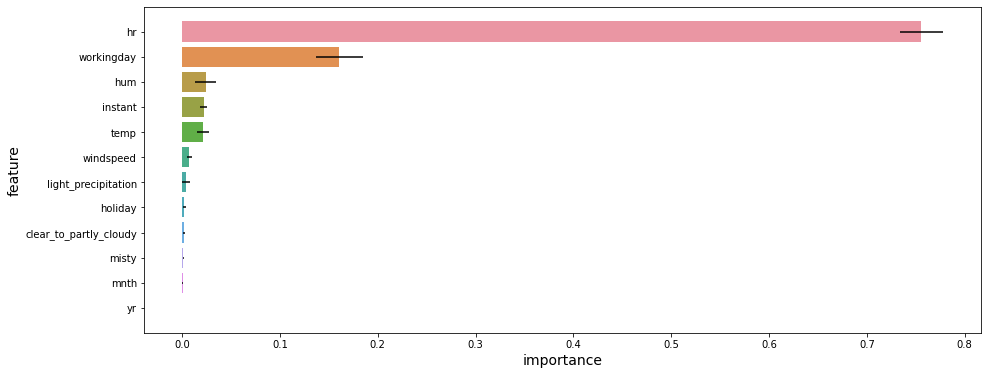

In [47]:
plot_feature_importances(X, rf)

### Gradient Boosting

In [48]:
# Instantiate gb
gb = GradientBoostingRegressor(max_depth=4, n_estimators=200, random_state=2)

# Fit gb to the training set
gb.fit(X_train, y_train)

# Predict test set labels
y_pred = gb.predict(X_test)

# Compute RMSE
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

# Print RMSE
print(f"Test set RMSE of gb: {rmse_test:.3f}")

Test set RMSE of gb: 43.113


### Stochastic Gradient Boosting

In [49]:
# Instantiate sgbr
sgbr = GradientBoostingRegressor(
    max_depth=4, subsample=0.9, max_features=0.75, n_estimators=200, random_state=2
)

# Fit sgbr to the training set
sgbr.fit(X_train, y_train)

# Predict test set labels
y_pred = sgbr.predict(X_test)

# Compute test set RMSE
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

# Print rmse_test
print(f"Test set RMSE of sgbr: {rmse_test:.3f}")

Test set RMSE of sgbr: 45.143


### RF w/ Grid Search

In [50]:
# Define the dictionary 'params_rf'
params_rf = dict(
    n_estimators=[100, 350, 500],
    max_features=["log2", "auto", "sqrt"],
    min_samples_leaf=[2, 10, 30],
)

# Instantiate RF
rf = RandomForestRegressor()
grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=params_rf,
    scoring="neg_mean_squared_error",
    cv=3,
    verbose=0,
    n_jobs=-1,
)
grid_rf.fit(X_train, y_train)

# Extract the best estimator
best_model = grid_rf.best_estimator_

# Predict test set labels
y_pred = best_model.predict(X_test)

# Compute test set RMSE
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

# Print rmse_test
print(f"Test set RMSE of grid_rf: {rmse_test:.3f}")

Test set RMSE of grid_rf: 51.846
